In [1]:
from Obstacle import *
from Visualization import *
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from Utils.Node import *
import math
import queue

wheel_radius = 0.038
wheel_distance = 0.354

In [2]:
obs = Obstacle(0.0)
viz = Visualization(obs)

In [3]:
# fig, ax = plt.subplots()
# ax.set(xlim=(0, 10), ylim = (0,10))
# obs = Obstacle(0.0)
# viz = Visualization(obs)
# ax = viz.addObstacles2Map(ax)
# ax.set_aspect("equal")
# # plt.show()

In [4]:
def checkGoalReached(current_node, goal_state, thresh_radius):
    current_state = current_node.getState()
    radius_sq = np.square(current_state[0] - goal_state[0]) + np.square(current_state[1] - goal_state[1])
    if radius_sq < thresh_radius**2:
        return True
    else:
        return False

In [5]:
def halfRound(n):
    return round(2*n)/2

In [6]:
def computeHeuristicCost(current_state, goal_state):
    cost = 0.0
    if current_state is not None:
        cost =  ((current_state[0]-goal_state[0])**2 + (current_state[1]-goal_state[1])**2)**(0.5)
    return cost

In [7]:
def checkVisited(node, node_array, goal_state, threshold=0.5):
    result = False
    node_state = node.getState()
    x = node_state[0]
    y = node_state[1]
    theta = node_state[2]
    x = int(halfRound(x)/threshold)
    y = int(halfRound(y)/threshold)

    if (node.getCost() + computeHeuristicCost(node_state, goal_state) < node_array[x, y, theta]):
        result = True
    return result

In [8]:
def toRadian(angle):
    return np.pi * angle / 180
def toDegree(angle):
    return 180 * angle / np.pi

In [9]:
def getBranches(node, T, w1, w2, obs):
    actions=[[w1, w1], [w2, w2], [w1, 0], [0, w1], [w1, w2], [w2, w1], [0, w2], [w2, 0]]
    state = node.getState()
    branches = []

    for action in actions:
        new_state, path_array, cost = move(state, action, T, obs)
        if new_state is not None:
            branch_node = Node(new_state, node, action, node.getCost() + cost, path_array)
            branches.append(branch_node)
      
    return branches



In [10]:
def move(state, action, T, obs):
    t = 0
    dt = 0.1
    
    Xi, Yi, thetai = state
    thetai = toRadian(thetai)

    wL, wR = action

    Xn = Xi
    Yn = Yi
    thetan = thetai

    path_array = []
    cost = 0.0
    path_array.append([Xn, Yn])
    while t<T:
        t = t + dt
        dx = 0.5 * wheel_radius * (wL + wR) * math.cos(thetan) * dt
        dy = 0.5 * wheel_radius * (wL + wR) * math.sin(thetan) * dt
        Xn += dx
        Yn += dy
        thetan += (wheel_radius / wheel_distance) * (wL - wR) * dt
        cost += math.sqrt(math.pow(dx,2) + math.pow(dy,2))
        path_array.append([Xn, Yn])
        
        if obs.isInObstacleSpace(Xn, Yn):
            return None, None, None
        
    thetan = int(toDegree(thetan))
    return [Xn, Yn, thetan] , path_array, cost

In [16]:
h,w = 10,10
threshold = 0.5
start_point = [1,1,0]
goal_state = [1,2]
w1, w2 = 5, 10
nodes = queue.PriorityQueue()
init_node = Node(start_point, None, None, 0, None)
nodes.put((init_node.getCost(), init_node))
traversed_nodes = []

goal_reached = False
node_array = np.array([[[math.inf for k in range(360)] for j in range(int(h/threshold))] for i in range(int(w/threshold))])

full_path = None
goal_reached = False
print('Finding path.........')

while (not nodes.empty()):
    current_node = nodes.get()[1]
    traversed_nodes.append(current_node)

    if checkGoalReached(current_node, goal_state,1):
        print('Goal reached')
        print("The cost of path: ", current_node.getCost())
        full_path, node_path = current_node.getFullPath()
        goal_reached = True

    else:
        branches = getBranches(current_node, 1, w1, w2, obs)
        for branch_node in branches:
            branch_state = branch_node.getState()
            if checkVisited(branch_node, node_array, goal_state, threshold=0.5):
                node_array[int(halfRound(branch_state[0])/threshold), int(halfRound(branch_state[1])/threshold), branch_state[2]] = branch_node.getCost() + computeHeuristicCost(branch_state, goal_state)
                nodes.put((branch_node.getCost() + computeHeuristicCost(branch_state, goal_state), branch_node))
    if (goal_reached): break


        

Finding path.........
Inside circle 1; avoid
Inside circle 1; avoid
Goal reached
The cost of path:  0.1045


None
[[1.0095, 1.0], [1.018986319876177, 1.0005096422341677], [1.0284316387799985, 1.0015274589195833], [1.0378087539468013, 1.0030505187176604], [1.0470906590404623, 1.0050744351764773], [1.0562506219323513, 1.0075933793638734], [1.065262261690558, 1.0106000966549251], [1.0740996245576635, 1.014085927625455], [1.0827372586982382, 1.0180408329913997], [1.0911502875007917, 1.0224534225222086], [1.099314481223062, 1.027310987845006]]


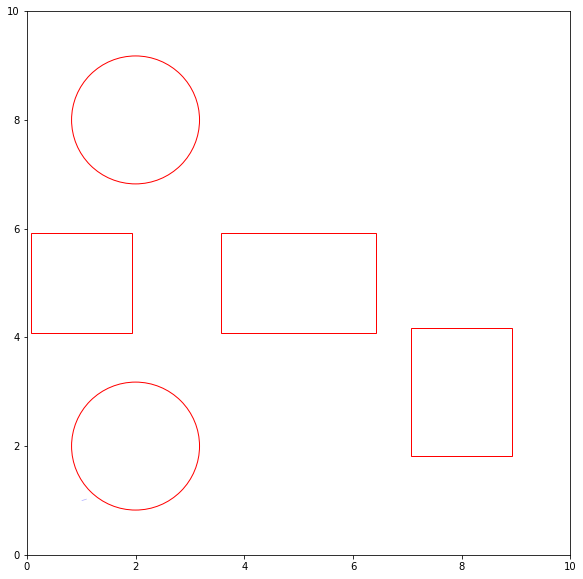

In [17]:
fig, ax = plt.subplots(figsize = (10, 10))
ax.set(xlim=(0, 10), ylim = (0,10))
ax = viz.addObstacles2Map(ax)
ax.set_aspect("equal")
for node in traversed_nodes:
    xi, yi, _ = node.getState()
    points = node.getPathArray()
    print(points)
    if points is not None:
        for point in points:
            xn, yn = point
            ax.plot([xi, xn], [yi, yn], color="blue", linewidth = 0.1 )
            xi, yi = xn, yn

    

In [13]:
len(traversed_nodes)

68